In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error
import os

In [18]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.precision', 2)

In [19]:
def create_predictions_dataset(results, dataset_type, file):
    """
    Create a long-format predictions dataset from results dictionary.
    
    Args:
        results (dict): Dictionary containing model results
        dataset_type (str): Either 'test' or 'train'
    
    Returns:
        pd.DataFrame: Long-format predictions dataset
    """
    # Get predictions based on dataset type
    preds = results[f'blended_{dataset_type}']
    
    # Rename columns for blended predictions
    preds.columns = ['blended_seed_' + str(col) for col in preds.columns if col != 'composite_score'] + ['composite_score']
    preds = preds.rename(columns={'composite_score': 'final'})
    
    # Process individual model predictions
    results_models = []
    for seed in results[f'models_{dataset_type}']:
        for model in results[f'models_{dataset_type}'][seed]:
            df_temp = results[f'models_{dataset_type}'][seed][model]
            
            # Rename columns
            model_name = model.replace('composite_score_', '')
            if model_name == 'linear1':
                model_name = 'linear_seed_' + str(seed)
            df_temp.columns = [model_name]
            results_models.append(df_temp)
    
    # Combine all predictions
    preds_models = pd.concat(results_models, axis=1)
    preds = pd.concat([preds, preds_models], axis=1)
    
    # Add metadata
    preds = pd.concat([preds, results[f'{dataset_type}_info']], axis=1)
    
    # Convert to long format
    id_vars = ['uid', 'year']
    if dataset_type == 'train':
        id_vars.append('combined_fold')

    # if dataset_type == 'test' and file == 'results_use_confact.pkl':
    #     id_vars.append('feature_category')
    
    preds = preds.melt(
        id_vars=id_vars,
        value_vars=preds.columns[~preds.columns.isin(id_vars)],
        var_name='model',
        value_name='predicted_score'
    )
    
    # Split model name and seed
    preds['seed'] = preds['model'].str.split('_seed_').str[1]
    preds['model'] = preds['model'].str.split('_seed_').str[0]
    
    return preds

def preprocess_results(results, test_labels, train_labels, file):
    test_preds = create_predictions_dataset(results, dataset_type='test', file=file)
    train_preds = create_predictions_dataset(results, dataset_type='train', file=file)
    test_preds = test_preds.merge(test_labels, on=['uid', 'year'], how='left')
    train_preds = train_preds.merge(train_labels, on=['uid', 'year'], how='left')
    results = {'test': test_preds, 'train': train_preds}
    return results

def calculate_rmse_by_group(data, group_by, target_col='predicted_score', true_col='composite_score'):
    """
    Calculate RMSE and number of samples for each group.
    
    Args:
        data (pd.DataFrame): Input dataframe
        group_by (str): Column to group by
        target_col (str): Column containing predictions
        true_col (str): Column containing true values
    
    Returns:
        pd.DataFrame: DataFrame with RMSE and sample counts for each group
    """
    # Calculate rmse and number of samples in each group in one dataframe
    rmse = data.groupby(group_by).apply(
        lambda x: root_mean_squared_error(x[target_col], x[true_col])
    )
    num_samples = data.groupby(group_by).size()
    df = pd.concat([rmse, num_samples], axis=1)
    df.columns = ['rmse', 'num_samples']
    return df

In [20]:
results_files = [f for f in os.listdir('../output') 
                 if os.path.isfile(os.path.join('../output', f)) 
                 and f.startswith('results_') 
                 and f.endswith('.pkl')]
test_labels = pd.read_csv('../data/raw/sdoh_test_labels.csv')
train_labels = pd.read_csv('../data/raw/train_labels.csv')

results_all = {}
for file in results_files:
    results = pd.read_pickle(f'../output/{file}')
    results = preprocess_results(results, test_labels, train_labels, file)
    results_type = file.replace('.pkl', '').replace('results_', '')
    results_all[results_type] = results

In [21]:
# Final model RMSE
test_data = results_all['spec_full']['test']
test_data = test_data[test_data['model'] == 'final']
np.round(root_mean_squared_error(test_data['predicted_score'], test_data['composite_score']), 2)

38.19

In [23]:
# Detect 
test_features = pd.read_csv('../data/raw/test_features.csv')
train_features = pd.read_csv('../data/raw/train_features.csv')
train_labels = pd.read_csv('../data/raw/train_labels.csv')
test_labels = pd.read_csv('../data/raw/sdoh_test_labels.csv')

features = pd.concat([train_features, test_features], axis=0).reset_index(drop=True)
labels = pd.concat([train_labels, test_labels], axis=0).reset_index(drop=True)

In [24]:
train_data = results_all['spec_full']['train']
np.round(root_mean_squared_error(train_data['predicted_score'], train_data['composite_score']), 2)

37.97

In [25]:
features['year_participation'] = features['age_03'].apply(lambda x: [2012] if type(x) == float else [2003, 2012])
year_participation_features_dict = features[['uid', 'year_participation']].set_index('uid')['year_participation'].to_dict()
year_participation_labels_dict = labels.groupby(['uid'])['year'].apply(lambda x: list(x)).to_dict()

In [26]:
# Add values from year_participation_labels_dict to year_participation_features_dict
year_participation_dict = {}
for uid in year_participation_features_dict:
    year_participation_dict[uid] = str(np.sort(year_participation_labels_dict[uid] + year_participation_features_dict[uid]))


# 1. Generalizability 

### Cross-Validation: Show consistent performance (mean and standard deviation) across validation folds.

In [27]:
train_data = results_all['spec_full']['train']
train_data = train_data[train_data['model'] == 'final']

In [28]:
train_data['year_participation'] = train_data['uid'].replace(year_participation_dict)

/var/folders/k2/l43pc0gj6311hvl_9yxc3kzc0000gn/T/ipykernel_57171/232524665.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['year_participation'] = train_data['uid'].replace(year_participation_dict)


In [29]:
# Mean value fold type
fold_rmse = calculate_rmse_by_group(train_data, 'combined_fold')


/var/folders/k2/l43pc0gj6311hvl_9yxc3kzc0000gn/T/ipykernel_57171/2122285187.py:82: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rmse = data.groupby(group_by).apply(


In [30]:
fold_rmse = fold_rmse.reset_index()

In [32]:
fold_rmse['fold_type'] = fold_rmse['combined_fold'].str[0] 
fold_rmse['fold_type'] = fold_rmse['fold_type'].apply(lambda x: 'two_year_scores' if int(x) > 0 else 'one_years_scores')

In [33]:
# RMSE by fold type mean and std in one dataframe   
fold_rmse = fold_rmse.groupby('fold_type').apply(lambda x: 
    pd.DataFrame({'rmse': x['rmse'].mean(), 'std': x['rmse'].std()}, index=[x['fold_type'].iloc[0]])
)
fold_rmse

/var/folders/k2/l43pc0gj6311hvl_9yxc3kzc0000gn/T/ipykernel_57171/3809858924.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  fold_rmse = fold_rmse.groupby('fold_type').apply(lambda x:


,,rmse,std
fold_type,,,
one_years_scores,one_years_scores,42.47,1.58
two_year_scores,two_year_scores,30.92,3.20


## Domain Shift Testing: Test performance under slight shifts in data distribution - e.g., feature removal.

In [34]:
test_data = results_all['drop_random_features']['test']
test_data = test_data[test_data['model'] == 'final']
print("RMSE for drop_random_features")
root_mean_squared_error(test_data['predicted_score'], test_data['composite_score'])

RMSE for drop_random_features


38.59350753079347

# 2. Robustness

### Random Seed Stability: Report performance across multiple random seeds (mean and standard deviation) – overall and by rows for each person

In [35]:
test_data = results_all['spec_full']['test']
test_data = test_data[test_data['model'] == 'blended']

In [36]:
# Mean and std RMSE for seed
seed_rmse = calculate_rmse_by_group(test_data, 'seed')
seed_rmse = seed_rmse.reset_index()
seed_rmse['rmse'].mean(), seed_rmse['rmse'].std()

/var/folders/k2/l43pc0gj6311hvl_9yxc3kzc0000gn/T/ipykernel_57171/2122285187.py:82: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rmse = data.groupby(group_by).apply(


(38.26798390817004, 0.049796485483270134)

In [37]:
test_data.groupby('uid')['predicted_score'].std().mean()

3.4089945843861864

### Perturbation Analysis: Test with systematic data modifications - e.g., outliers by income variables

In [38]:
test_data = results_all['replace_outliers']['test']
test_data = test_data[test_data['model'] == 'final']
print("RMSE for replace_outliers")
root_mean_squared_error(test_data['predicted_score'], test_data['composite_score'])

RMSE for replace_outliers


38.26906409841147

In [39]:
test_data = results_all['remove_na_obs']['test']
test_data = test_data[test_data['model'] == 'final']
print("RMSE for remove_na_obs")
root_mean_squared_error(test_data['predicted_score'], test_data['composite_score'])

RMSE for remove_na_obs


38.25736849737435

# 3. Performance

### Metrics and Results: Overall model performance estimates, including metrics chosen (and justification for their use ??) - performance on the primary outcome overall, by years, and absolute difference between the years for cognitive decline predictions. 

In [40]:
# Create a dataframe to compare model performance across different specifications
table_spec_model_rmse = pd.DataFrame(columns=['spec', 'model', 'rmse'])
rmse_data = []

for key in ['spec_1', 'spec_2', 'spec_3', 'spec_full']:
    for model in ['final', 'blended', 'linear', 'catboost_0', 'lgbm_1', 'xgboost_2']:
        test_data = results_all[key]['test']
        test_data = test_data[test_data['model'] == model]
        rmse_data.append({
            'spec': key, 
            'model': model, 
            'rmse': root_mean_squared_error(test_data['predicted_score'], test_data['composite_score'])
        })

table_spec_model_rmse = pd.DataFrame(rmse_data)

In [41]:
# To wide format
table_spec_model_rmse = table_spec_model_rmse.pivot(index='spec', columns='model', values='rmse')
table_spec_model_rmse = table_spec_model_rmse[['catboost_0', 'lgbm_1', 'xgboost_2', 'linear', 'final']]

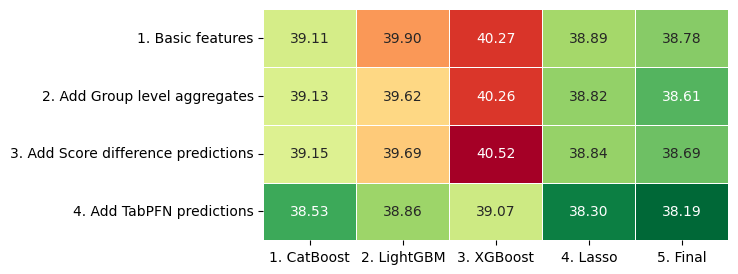

In [42]:
# Replace names of the models
table_spec_model_rmse = table_spec_model_rmse.rename(columns={'catboost_0':'1. CatBoost',
                                      'lgbm_1': '2. LightGBM',
                                      'xgboost_2': '3. XGBoost',
                                      'linear': '4. Lasso',
                                      'final': '5. Final'})

table_spec_model_rmse = table_spec_model_rmse.rename(index={'spec_1':'1. Basic features',
                                                            'spec_2': '2. Add Group level aggregates',
                                                            'spec_3': '3. Add Score difference predictions',
                                                            'spec_full': '4. Add TabPFN predictions'})

# To heatmap
plt.figure(figsize=(6, 3))

sns.heatmap(table_spec_model_rmse, 
            annot=True, 
            fmt='.2f',
            cmap='RdYlGn_r', 
            cbar=False,
            # cbar_kws={'label': 'RMSE'}, 
            annot_kws={'size': 10}, 
            # square=True,
            linewidths=.5,  # Add white borders between cells
            linecolor='white')  # Set border color to white
plt.xticks(rotation=0, fontsize=10)
plt.yticks(rotation=0, fontsize=10) 
# plt.title('RMSE for each specification and model')
# plt.xlabel('Model')
# plt.ylabel('Specification')
plt.xlabel('')
plt.ylabel('')
plt.show()

In [43]:
test_data = results_all['spec_full']['test']
test_data = test_data[test_data['model'] == 'final']
test_data['year_participation'] = test_data['uid'].replace(year_participation_dict)

/var/folders/k2/l43pc0gj6311hvl_9yxc3kzc0000gn/T/ipykernel_57171/2429677331.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['year_participation'] = test_data['uid'].replace(year_participation_dict)


In [44]:
rmse_year_participation = calculate_rmse_by_group(test_data, 'year_participation')
rmse_year_participation = rmse_year_participation.sort_values(by='rmse', ascending=True)
rmse_year_participation['Features 2003'] = list(map(lambda x: '2003' in x, rmse_year_participation.index))
rmse_year_participation['Features 2012'] = list(map(lambda x: '2012' in x, rmse_year_participation.index))
rmse_year_participation['Scores 2016'] = list(map(lambda x: '2016' in x, rmse_year_participation.index))
rmse_year_participation['Scores 2021'] = list(map(lambda x: '2021' in x, rmse_year_participation.index))
rmse_year_participation['rmse_n'] = rmse_year_participation.apply(lambda x: str(np.round(x['rmse'], 2)), axis=1)
rmse_year_participation = rmse_year_participation.set_index('rmse_n')
rmse_year_participation = rmse_year_participation.drop(columns=['rmse', 'num_samples'])

/var/folders/k2/l43pc0gj6311hvl_9yxc3kzc0000gn/T/ipykernel_57171/2122285187.py:82: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rmse = data.groupby(group_by).apply(


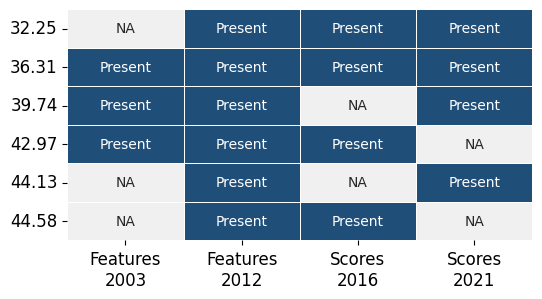

In [45]:
plt.figure(figsize=(6, 3))

# Create heatmap with binary colors and text annotations
sns.heatmap(rmse_year_participation, 
            annot=rmse_year_participation.replace({True: 'Present', False: 'NA'}),  # Add custom text labels
            fmt='',  # Use empty format to display text as-is
            # cmap=['grey', 'black'],  # Binary colormap: white for 0, green for 1
            # cmap=['white', '#1f4e79'],
            cmap=['#f0f0f0','#1f4e79'],
            cbar=False,  # Remove colorbar
            linewidths=0.5,  # Add cell borders
            linecolor='white',  # Set border color to black
            annot_kws={'size': 10})  # Set annotation text size
plt.xlabel('')
plt.ylabel('')
plt.yticks(rotation=0, fontsize=12) 

# Rotate x-axis labels and add newline
plt.xticks(rotation=0, fontsize=12)  # Make labels horizontal
current_labels = plt.gca().get_xticklabels()
new_labels = [label.get_text().replace(' ', '\n') for label in current_labels]
plt.gca().set_xticklabels(new_labels)

plt.show()

In [46]:
list_dfs = []

for key in ['spec_1', 'spec_2', 'spec_3', 'spec_full']:

    test_data = results_all[key]['test']
    test_data = test_data[test_data['model'] == 'final']
    test_data['spec'] = key
    
    list_dfs.append(test_data)

test_data_spec = pd.concat(list_dfs)

/var/folders/k2/l43pc0gj6311hvl_9yxc3kzc0000gn/T/ipykernel_57171/389759019.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['spec'] = key
/var/folders/k2/l43pc0gj6311hvl_9yxc3kzc0000gn/T/ipykernel_57171/389759019.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['spec'] = key
/var/folders/k2/l43pc0gj6311hvl_9yxc3kzc0000gn/T/ipykernel_57171/389759019.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

In [47]:
# RMSE by 5-quantiles of composite score, rename quantiles to q1, q2, q3, q4, q5
test_data_spec['composite_score_quantiles'] = pd.qcut(
    test_data_spec['composite_score'], 5)
test_data_spec['composite_score_quantiles'] = test_data_spec[
    'composite_score_quantiles'].cat.rename_categories(['q1', 'q2', 'q3', 'q4', 'q5'])

In [48]:
# Calculate RMSE by quantiles and specification
agg_quantiles_spec = test_data_spec.groupby(['composite_score_quantiles', 'spec']).apply(
    lambda x: root_mean_squared_error(x['predicted_score'], x['composite_score'])
)
agg_quantiles_spec = agg_quantiles_spec.reset_index()
agg_quantiles_spec = agg_quantiles_spec.rename(columns={'composite_score_quantiles': 'quantile', 0: 'rmse'})
agg_quantiles_spec = agg_quantiles_spec.pivot(index='quantile', columns='spec', values='rmse')

/var/folders/k2/l43pc0gj6311hvl_9yxc3kzc0000gn/T/ipykernel_57171/3902882661.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg_quantiles_spec = test_data_spec.groupby(['composite_score_quantiles', 'spec']).apply(
/var/folders/k2/l43pc0gj6311hvl_9yxc3kzc0000gn/T/ipykernel_57171/3902882661.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  agg_quantiles_spec = test_data_spec.groupby(['composite_score_quantiles', 'spec']).apply(


In [49]:
agg_quantiles_spec = agg_quantiles_spec.rename(
    index={'q1': 'Q1', 'q2': 'Q2', 'q3': 'Q3', 'q4': 'Q4', 'q5': 'Q5'})
agg_quantiles_spec = agg_quantiles_spec.rename(
    columns={'spec_1': '1. Basic features', 'spec_2': '2. + Group level aggregates', 'spec_3': '3. + Score difference predictions', 'spec_full': '4. + TabPFN predictions'})

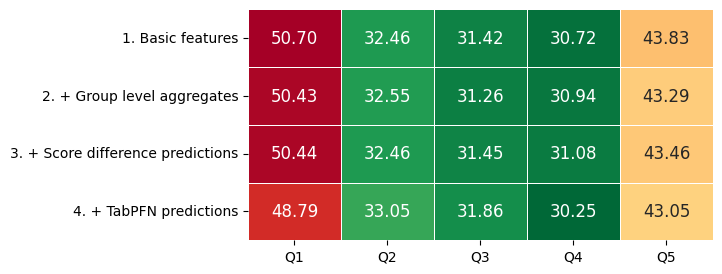

In [50]:
plt.figure(figsize=(6, 3))

sns.heatmap(agg_quantiles_spec.T,
            annot=True,
            fmt='.2f',
            cmap='RdYlGn_r',
            cbar=False,
            linewidths=0.5,  # Add cell borders
            linecolor='white',  # Set border color to black
            annot_kws={'size': 12},
            square=False)
plt.xlabel('')
plt.ylabel('')
plt.show()

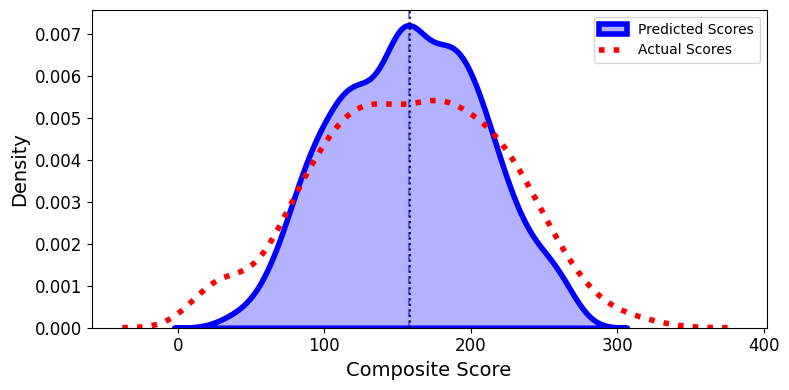

In [51]:
# Create visualization with filled kernel density for predicted and line for actual
plt.figure(figsize=(8, 4))

# Create filled kernel density plot for predicted scores
sns.kdeplot(data=test_data, x='predicted_score', 
            label='Predicted Scores', color='blue', 
            fill=True, alpha=0.3, linewidth=4)

# Add actual scores as kernel density line
sns.kdeplot(data=test_data, x='composite_score', 
            label='Actual Scores', color='red', 
            linestyle=':', linewidth=4)

# Customize the plot
# plt.title('Distribution of Predicted vs Actual Composite Scores', fontsize=12)
plt.xlabel('Composite Score', fontsize=14)
plt.ylabel('Density', fontsize=14)

plt.yticks(fontsize=12) 
plt.xticks(fontsize=12) 
plt.legend()

# Add mean lines
plt.axvline(test_data['predicted_score'].mean(), color='blue', linestyle='--', alpha=0.5,
            label=f'Pred. Mean: {test_data["predicted_score"].mean():.1f}')
plt.axvline(test_data['composite_score'].mean(), color='black', linestyle=':', alpha=0.8,
            label=f'Actual Mean: {test_data["composite_score"].mean():.1f}')

# Adjust layout
plt.tight_layout()
plt.show()

# 4. Bias and Ethics

In [52]:
import warnings
warnings.filterwarnings('ignore')

### Model Bias: Analysis of potential biases in the model’s predictions, including subpopulation error analysis. Show bias for by gender, race, year_participation, etc. for each model and all other hyperparameter such as non-interpretable features, TabPFN quantiles, relative difference model – how they make predictions less biased by groups.

In [53]:
list_models = ['catboost_0', 'lgbm_1', 'xgboost_2', 'linear', 'blended', 'final']
list_group_by = ['year', 'age_12', 'ragender', 'edu_gru_12']

In [58]:
def calculate_rmse_by_group(data, group_by, target_col='predicted_score', true_col='composite_score'):
    """
    Calculate RMSE and number of samples for each group.
    
    Args:
        data (pd.DataFrame): Input dataframe
        group_by (str): Column to group by
        target_col (str): Column containing predictions
        true_col (str): Column containing true values
    
    Returns:
        pd.DataFrame: DataFrame with RMSE and sample counts for each group
    """
    # Calculate rmse for each group
    rmse = data.groupby(group_by, group_keys=False, observed=True).apply(
        lambda x: root_mean_squared_error(x[target_col], x[true_col]),
        include_groups=False
    )
    rmse = pd.DataFrame(rmse, columns=['rmse'])
    
    # Calculate number of samples for each group
    num_samples = data.groupby(group_by, observed=True).size()
    num_samples = pd.DataFrame(num_samples, columns=['num_samples'])
    
    # Combine the results
    df = pd.concat([rmse, num_samples], axis=1)
    return df

def calculate_rmse_by_group_model(model, group_by):
    """
    Calculate RMSE by group for a specific model.
    
    Args:
        model (str): Name of the model
        group_by (str): Column to group by
    
    Returns:
        pd.DataFrame: DataFrame with RMSE values for each group
    """
    test_data = results_all['spec_full']['test']
    test_data = test_data[test_data['model'] == model]
    test_features = pd.read_csv('../data/raw/test_features.csv')
    test_data = test_data.merge(test_features, on=['uid'], how='left')

    # Split by income by beans
    test_data['hincome_12_bins'] = pd.qcut(test_data['hincome_12'], 3)
    test_data['hincome_12_bins'] = test_data['hincome_12_bins'].cat.rename_categories(['q1', 'q2', 'q3'])
    
    # Calculate RMSE and reset index to make group_by column a regular column
    model_rmse = calculate_rmse_by_group(test_data, group_by)
    model_rmse = model_rmse.drop(columns=['num_samples']).reset_index()
    model_rmse['model'] = model
    
    return model_rmse

def create_rmse_comparison_table(list_models, group_by='year'):
    """
    Creates a comparison table of RMSE values across different models for a given grouping variable.
    
    Args:
        list_models (list): List of model names to compare
        group_by (str): Column name to group results by (default: 'year')
    
    Returns:
        pd.DataFrame: Wide-format table with RMSE values for each model and group
    """
    # Calculate RMSE for each model
    list_rmse_by_model = []
    for model in list_models:
        list_rmse_by_model.append(calculate_rmse_by_group_model(model, group_by))
    
    # Combine results and reshape to wide format
    rmse_by_model = pd.concat(list_rmse_by_model)
    rmse_by_model = rmse_by_model.pivot(
        index=group_by, 
        columns='model', 
        values='rmse'
    )
    rmse_by_model = rmse_by_model[list_models]

    
    return rmse_by_model

In [59]:
test_data = results_all['spec_full']['test']
test_data = test_data[test_data['model'] == 'final']
test_features = pd.read_csv('../data/raw/test_features.csv')
test_data = test_data.merge(test_features, on=['uid'], how='left')

In [60]:
rmse_age = create_rmse_comparison_table(list_models, ['age_12'])
rmse_gender =create_rmse_comparison_table(list_models, ['ragender'])
rmse_edu = create_rmse_comparison_table(list_models, ['edu_gru_12'])
rmse_urban = create_rmse_comparison_table(list_models, ['urban_12'])
rmse_income = create_rmse_comparison_table(list_models, ['hincome_12_bins'])

In [61]:
def calcluate_fairness_metric_df(df):
    # For each column calculate the fairness metric = 1 - (range of the column) / (max of the column). BY COLUM of df
    return 1 - (df.max(0) - df.min(0)) / df.max(0)


In [62]:
fairness_metrics_table = pd.concat([
           calcluate_fairness_metric_df(rmse_gender),
           calcluate_fairness_metric_df(rmse_age),
           calcluate_fairness_metric_df(rmse_edu),
           calcluate_fairness_metric_df(rmse_income),
           calcluate_fairness_metric_df(rmse_urban)
           ], axis=1)
fairness_metrics_table.columns = ['gender', 'age', 'edu', 'income', 'urban']
fairness_metrics_table = fairness_metrics_table.drop(['blended'])

In [63]:
fairness_metrics_table = fairness_metrics_table.astype(float)

### Weights by inverse fairness

In [64]:
def calculate_fairness_metric(rmse_by_group):
    fairness_scores = 1 - ((max(rmse_by_group) - min(rmse_by_group)) / max(rmse_by_group)) 
    return fairness_scores


In [65]:
# test_data['predicted_score_constrained'] = y_pred_adj

def get_fairness_metrics(test_data, protected_score):

    rmse_age = calculate_rmse_by_group(test_data, 'age_12', target_col=protected_score, true_col='composite_score')
    rmse_gender = calculate_rmse_by_group(test_data, 'ragender', target_col=protected_score, true_col='composite_score')
    rmse_edu = calculate_rmse_by_group(test_data, 'edu_gru_12', target_col=protected_score, true_col='composite_score')
    rmse_urban = calculate_rmse_by_group(test_data, 'urban_12', target_col=protected_score, true_col='composite_score')
    rmse_income = calculate_rmse_by_group(test_data, 'hincome_12_bins', target_col=protected_score, true_col='composite_score')

    def calculate_fairness_metric(rmse_by_group):
        fairness_scores = 1 - ((max(rmse_by_group) - min(rmse_by_group)) / max(rmse_by_group)) 
        return fairness_scores

    fairness_age = calculate_fairness_metric(rmse_age['rmse'])
    fairness_gender = calculate_fairness_metric(rmse_gender['rmse'])
    fairness_edu = calculate_fairness_metric(rmse_edu['rmse'])
    fairness_urban = calculate_fairness_metric(rmse_urban['rmse'])
    fairness_income = calculate_fairness_metric(rmse_income['rmse'])

    fairness_metrics_table = pd.DataFrame([{
    'gender': fairness_gender,
    'age': fairness_age,
    'edu': fairness_edu,
    'income': fairness_income,
    'urban': fairness_urban}])

    return fairness_metrics_table



In [67]:
def preprocess_data(results_all, data_type='test'):

    data = results_all['spec_full'][data_type]
    data = data[data['model'] == 'linear']
    data = data.reset_index(drop=True)

    # to wide, add suffix to columns seed_
    data_wide = data.pivot(index=['uid', 'year'], columns='seed', values='predicted_score')
    data_wide.columns = [f'seed_{col}' for col in data_wide.columns]
    data_wide = data_wide.reset_index(drop=False)
    data_wide = data_wide.merge(data.drop_duplicates(['uid', 'year'])[['uid', 'year', 'predicted_score', 'composite_score']])

    features = pd.read_csv(f'../data/raw/{data_type}_features.csv')

    # Split by income bins
    features['hincome_12_bins'] = pd.qcut(features['hincome_12'], 3, duplicates='drop')
    features['hincome_12_bins'] = features['hincome_12_bins'].cat.rename_categories(['q1', 'q2', 'q3'])

    columns_to_keep = ['uid', 'ragender', 'age_12', 'edu_gru_12', 'urban_12', 'hincome_12_bins']
    features = features.loc[:, columns_to_keep]

    data_wide = data_wide.merge(features, on=['uid'], how='left')

    return data_wide

train_data = preprocess_data(results_all, data_type='train')
test_data = preprocess_data(results_all, data_type='test')

In [68]:
train_data['group'] = train_data['age_12'].fillna('missing')
test_data['group'] = test_data['age_12'].fillna('missing')

In [69]:
rmse_group = calculate_rmse_by_group(train_data, 'group', target_col='predicted_score', true_col='composite_score')
rmse_group = rmse_group.drop(columns=['num_samples']).reset_index()
rmse_group = dict(zip(rmse_group['group'], rmse_group['rmse']))

rmse_values = pd.Series(list(rmse_group.values()))

def softmax(values, temperature=1.0):
    exp_values = np.exp((values - np.max(values)) / temperature)  # Subtract max for stability
    return ((exp_values / np.sum(exp_values)) * 1)

# rmse_values = softmax(rmse_values, 10)
rmse_values = softmax(rmse_values, 10)
dict_rmse_weights = dict(zip(rmse_group.keys(), rmse_values.tolist()))

In [70]:
# --- Version softmax
train_data['weights'] = train_data['group'].map(dict_rmse_weights)
test_data['weights'] = test_data['group'].map(dict_rmse_weights)

In [71]:
import pandas as pd
from catboost import CatBoostRegressor, Pool

# ------------------------------------------------
# 2. PREPARE FEATURES & TARGET
# ------------------------------------------------
# Define your target and weight columns:
target_col = 'composite_score'
weight_col = 'weights'

# Define categorical features (as appropriate for your data).
# Adjust the indexing or column names as needed:
cat_features = ['ragender', 'age_12', 'edu_gru_12', 'urban_12', 'hincome_12_bins', 'group']

# Drop columns that are identifiers or not useful as features:
ignored_cols = ['uid', 'model', 'combined_fold', 'group_rmse', 'composite_score', 'weights']

# The rest of the columns can be used as features:
feature_cols = [col for col in train_data.columns if col not in ignored_cols]

X_train = train_data[feature_cols]
y_train = train_data[target_col]
w_train = train_data[weight_col]

# Similarly for test data (make sure it has the same columns):
X_test = test_data[feature_cols]

# Replace NaN values in categorical features with a placeholder
for col in cat_features:
    if col in X_train.columns:
        # If the column is categorical, add "missing" as a new category
        if X_train[col].dtype.name == "category":
            X_train[col] = X_train[col].cat.add_categories("missing")
            X_test[col] = X_test[col].cat.add_categories("missing")
        # Fill NaN values with the "missing" category
        X_train[col] = X_train[col].fillna("missing")
        X_test[col] = X_test[col].fillna("missing")


# ------------------------------------------------
# 3. CREATE POOL OBJECTS (OPTIONAL BUT OFTEN USEFUL)
# ------------------------------------------------
train_pool = Pool(
    data=X_train,
    label=y_train,
    cat_features=[X_train.columns.get_loc(col) for col in cat_features if col in X_train.columns],
    weight=w_train
)

# If you need a Pool for the test set (to handle categorical features properly),
# you can create one as well (without labels, since we want to predict):
test_pool = Pool(
    data=X_test,
    cat_features=[X_test.columns.get_loc(col) for col in cat_features if col in X_test.columns]
)

# ------------------------------------------------
# 4. DEFINE AND TRAIN CATBOOST MODEL
# ------------------------------------------------
# For regression, use CatBoostRegressor:
model = CatBoostRegressor(
    iterations=1000,      # increase or tune for better performance
    learning_rate=0.03,   # tune as necessary
    depth=6,              # tune as necessary
    loss_function='RMSE', # typical for regression
    random_seed=42,       # for reproducibility
    verbose=100           # to see training progress
)

# Train the model using the Pool
model.fit(train_pool, eval_set=test_pool)  # optionally use test_pool for evaluation

# ------------------------------------------------
# 5. PREDICT ON TEST DATA
# ------------------------------------------------
test_predictions = model.predict(test_pool)

# If you want to attach predictions back to your test DataFrame:
test_data['predicted_score_weighted'] = test_predictions


0:	learn: 60.4479499	total: 59.3ms	remaining: 59.3s
100:	learn: 37.5353968	total: 272ms	remaining: 2.42s
200:	learn: 36.8449942	total: 454ms	remaining: 1.81s
300:	learn: 36.3880413	total: 641ms	remaining: 1.49s
400:	learn: 36.1026229	total: 832ms	remaining: 1.24s
500:	learn: 35.7525244	total: 1.02s	remaining: 1.01s
600:	learn: 35.4371176	total: 1.21s	remaining: 801ms
700:	learn: 35.1007083	total: 1.4s	remaining: 598ms
800:	learn: 34.7072140	total: 1.58s	remaining: 394ms
900:	learn: 34.2953088	total: 1.79s	remaining: 196ms
999:	learn: 33.8871042	total: 1.99s	remaining: 0us


In [72]:
fairness_metrics_adjusted = get_fairness_metrics(test_data, 'predicted_score_weighted')

In [73]:
fairness_metrics_adjusted.index = ['fairness_adjusted']

In [74]:
fairness_metrics_table = pd.concat([fairness_metrics_table, fairness_metrics_adjusted])

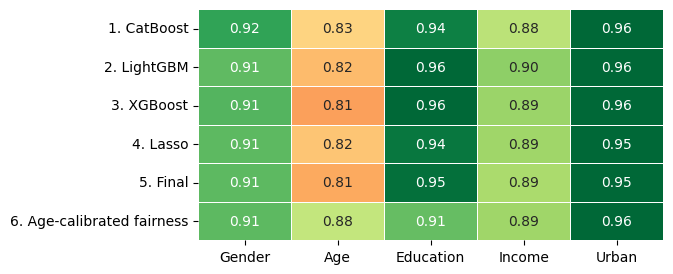

In [75]:
# Replace names of the models
fairness_metrics_table = fairness_metrics_table.rename(index={'catboost_0':'1. CatBoost',
                                      'lgbm_1': '2. LightGBM',
                                      'xgboost_2': '3. XGBoost',
                                      'linear': '4. Lasso',
                                      'final': '5. Final',
                                      'fairness_adjusted': '6. Age-calibrated fairness'})

fairness_metrics_table = fairness_metrics_table.rename(columns={'gender':'Gender',
                                                                  'age':'Age',
                                                                  'edu':'Education',
                                                                  'income':'Income',
                                                                  'urban':'Urban'})

plt.figure(figsize=(6, 3))

# To heatmap
sns.heatmap(fairness_metrics_table,
            annot=True,
            fmt='.2f',
            center=0.85,
            vmin=0.8,
            vmax=0.95,
            cmap='RdYlGn',
            # cbar_kws={'label': 'Fairness metric'},
            linewidths=0.5,  # Add cell borders
            linecolor='white',  # Set border color to black
            cbar=False,
            annot_kws={'size': 10},
            square=False
            )
plt.xlabel('')
plt.ylabel('')
plt.show()

In [76]:
print("RMSE for fairness adjusted model:", f"{root_mean_squared_error(test_data['composite_score'], test_data['predicted_score_weighted']):.2f}")

RMSE for fairness adjusted model: 38.95


# 5. Explainability and Insights

### Model Explainability: Explanation of how the model generates predictions. Simulations by key social factors.

### 5.1 Model explainability by all feature-categories

In [121]:
from tqdm import tqdm

In [122]:
results_files = list(os.listdir('../output/confact/'))
test_labels = pd.read_csv('../data/raw/sdoh_test_labels.csv')
train_labels = pd.read_csv('../data/raw/train_labels.csv')

results_confact = {}
for file in tqdm(results_files):
    # read only pkl files
    if file.endswith('.pkl'):
        results = pd.read_pickle(f'../output/confact/{file}')
        results = preprocess_results(results, test_labels, train_labels, file)
        results_type = file.replace('.pkl', '').replace('results_', '')
        results_confact[results_type] = results

100%|██████████| 245/245 [01:04<00:00,  3.80it/s]


In [123]:
def scale_confidence_interval(lower, upper, current_size, expected_size):
    scale_factor = np.sqrt(current_size / expected_size)
    mean = (upper + lower) / 2
    margin = (upper - lower) / 2
    scaled_margin = margin * scale_factor
    return mean - scaled_margin, mean + scaled_margin

def scale_se(se, current_size, expected_size):
    scale_factor = np.sqrt(current_size / expected_size)
    return se * scale_factor

In [124]:
# ----- SE -----
import numpy as np
from tqdm import tqdm


def bootstrap_confidence_intervals(data, n_bootstraps=1000):  # Removed confidence_level since SE-based CI is used
    """
    Calculate mean and confidence intervals using SE from bootstrap samples.

    Args:
        data (pd.DataFrame): Input data containing 'predicted_score'.
        n_bootstraps (int): Number of bootstrap iterations.

    Returns:
        tuple: Mean, lower bound, and upper bound.
    """
    mean = data['predicted_score'].mean()  # Calculate the original mean

    bootstrap_means = []
    for _ in range(n_bootstraps):
        # Bootstrap sampling
        bootstrap_sample = data.sample(frac=1, replace=True)
        bootstrap_mean = bootstrap_sample['predicted_score'].mean()
        bootstrap_means.append(bootstrap_mean)

    # Calculate standard error (SE) from bootstrapped means
    se = np.std(bootstrap_means, ddof=1)
    se = scale_se(se, len(data), (len(data) + len(train_labels)))

    # Calculate lower and upper bounds
    lower_bound = mean - se
    upper_bound = mean + se

    return mean, lower_bound, upper_bound


# ----- Main Loop -----
confact_score = {}
for key in tqdm(results_confact):
    results_test = results_confact[key]['test']
    results_test = results_test[results_test['model'] == 'final']

    # Split data by year
    results_test_2016 = results_test[results_test['year'] == 2016]
    results_test_2021 = results_test[results_test['year'] == 2021]

    # Calculate mean and bounds for each year
    mean_2016, lower_bound_2016, upper_bound_2016 = bootstrap_confidence_intervals(results_test_2016)
    mean_2021, lower_bound_2021, upper_bound_2021 = bootstrap_confidence_intervals(results_test_2021)

    # Optionally scale confidence intervals
    lower_bound_2016, upper_bound_2016 = scale_confidence_interval(
        lower_bound_2016, upper_bound_2016, len(test_labels), (len(test_labels) + len(train_labels))
    )
    lower_bound_2021, upper_bound_2021 = scale_confidence_interval(
        lower_bound_2021, upper_bound_2021, len(test_labels), (len(test_labels) + len(train_labels))
    )

    # Store results
    results_dict = {
        'mean_2016': mean_2016,
        'lower_bound_2016': lower_bound_2016,
        'upper_bound_2016': upper_bound_2016,
        'mean_2021': mean_2021,
        'lower_bound_2021': lower_bound_2021,
        'upper_bound_2021': upper_bound_2021,
    }

    confact_score[key] = results_dict

100%|██████████| 244/244 [00:29<00:00,  8.28it/s]


In [125]:
confact_score = pd.DataFrame(confact_score).T
confact_score = confact_score.reset_index()
confact_score['feature'] = confact_score['index'].str.split('@').str[0].replace('use_confact_test_features_confact_', '')
confact_score['category'] = confact_score['index'].str.split('@').str[1]
confact_score = confact_score.drop(columns=['index'])
confact_score = confact_score.rename(columns={2016: 'year_2016', 2021: 'year_2021'})
confact_score['feature'] = confact_score['feature'].str.replace('use_confact_test_features_confact_', '')

In [126]:
test_data_original = results_all['spec_full']['test']
test_data_original = test_data_original[test_data_original['model'] == 'final']
year_avg_predicted_score = test_data_original.groupby(['year'])['predicted_score'].mean().sort_values(ascending=False)

In [127]:
score_2016, score_2021 = year_avg_predicted_score[2016], year_avg_predicted_score[2021]

In [128]:
def normalize_score(score, score_original):
    return (score - score_original) / score_original * 100

In [129]:
confact_score['mean_2016'] = confact_score['mean_2016'].apply(lambda x: normalize_score(x, score_2016))
confact_score['mean_2021'] = confact_score['mean_2021'].apply(lambda x: normalize_score(x, score_2021))
confact_score['lower_bound_2016'] = confact_score['lower_bound_2016'].apply(lambda x: normalize_score(x, score_2016))
confact_score['lower_bound_2021'] = confact_score['lower_bound_2021'].apply(lambda x: normalize_score(x, score_2021))
confact_score['upper_bound_2016'] = confact_score['upper_bound_2016'].apply(lambda x: normalize_score(x, score_2016))
confact_score['upper_bound_2021'] = confact_score['upper_bound_2021'].apply(lambda x: normalize_score(x, score_2021))

In [130]:
# Get top and bottom 10 scores
sort_by_column = 'mean_2021'

top_5 = confact_score.nlargest(5, sort_by_column)
top_5 = top_5.sort_values(sort_by_column, ascending=True)
bottom_5 = confact_score.nsmallest(5, sort_by_column)
bottom_5 = bottom_5.sort_values(sort_by_column, ascending=True)
plot_data = pd.concat([bottom_5, top_5])

def plot_confact_score(plot_data, add_horizontal_line=True):
    """
    Plots mean differences with confidence intervals for 2016 and 2021 data
    with an offset to avoid overlapping.

    Args:
        plot_data (pd.DataFrame): Data containing 'mean_2016', 'mean_2021',
                                  'lower_bound_2016', 'upper_bound_2016',
                                  'lower_bound_2021', 'upper_bound_2021', etc.
        add_horizontal_line (bool): Whether to add a horizontal line to separate
                                    top and bottom 10 features.
    """
    # Create figure with larger size
    plt.figure(figsize=(10, 5))

    # Offset for separating 2016 and 2021 points
    offset = 0.1

    # Define y-axis positions
    y_positions = range(len(plot_data))

    # Plot 2016 data (shifted slightly downward)
    plt.errorbar(plot_data['mean_2016'], 
                 [y - offset for y in y_positions],  # Shift downward
                 xerr=[
                     plot_data['mean_2016'] - plot_data['lower_bound_2016'], 
                     plot_data['upper_bound_2016'] - plot_data['mean_2016']
                 ],
                 fmt='o', color='#63a7e6', label='2016', capsize=3, alpha=1)

    # Plot 2021 data (shifted slightly upward)
    plt.errorbar(plot_data['mean_2021'], 
                 [y + offset for y in y_positions],  # Shift upward
                 xerr=[
                     plot_data['mean_2021'] - plot_data['lower_bound_2021'],
                     plot_data['upper_bound_2021'] - plot_data['mean_2021']
                 ],
                 fmt='o', color='#1f4e79', label='2021', capsize=3, alpha=1)

    # Customize the plot
    plt.axvline(x=0, color='gray', linestyle='--', alpha=0.5)

    plt.grid(True, alpha=0.3)
    plt.xlabel('Change in Cognitive Score from Baseline (%)', fontsize=12)
    # plt.title('Top and Bottom 5 Feature Categories', fontsize=14, pad=20)

    # Create combined feature and category labels
    labels = [f"{row['feature_category']}" for _, row in plot_data.iterrows()]
    plt.yticks(y_positions, labels)

    # Increase X-axis tick label font size
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12) 

    # Add legend
    plt.legend(loc='lower right')

    # Add "Top-5" and "Bottom-5" labels
    plt.text(-6, 7, 'Top-5', fontsize=16)  # Adjust x-coordinate (-25) as needed
    plt.text(-6, 2, 'Bottom-5', fontsize=16)  # Adjust x-coordinate (-25) as needed

    # Optionally add horizontal line to separate top and bottom features
    if add_horizontal_line:
        plt.axhline(y=4.5, color='gray', linestyle='--', alpha=0.5)

    # Adjust layout
    plt.tight_layout()
    plt.show()

In [131]:
plot_data['feature_category'] = plot_data['feature'] + ':' + plot_data['category']

In [132]:
dict_feature_category = {
    "age:3": "Age group (2003) - 3. 70–79",
    "memory:5__Poor": "Self-reported memory - 5: Poor",
    "n_depr:4_0": "Number of CES-D depressive symptoms - 4",
    "n_depr:8_0": "Number of CES-D depressive symptoms - 8",
    "edu_gru:0__No_education": "Education level - 0: No education",
    "n_living_child:0__No_children": "Number of living children - 0: No children",
    "n_depr:5_0": "Number of CES-D depressive symptoms - 5",
    "age:2": "Age group (2003) - 2. 60–69",
    "hard:1_0": "Felt that everything was an effort (past week) - True",
    "decis_personal:2_0": "Weight over personal decisions - 2",
    "arthritis:1_0": "Diagnosed with arthritis/rheumatism - True",
    "edu_gru:3__7–9_years": "Education level - 3: 7–9 years",
    "age:1": "Age group (2003) - 1. 50–59",
    "n_depr:3_0": "Number of CES-D depressive symptoms - 3",
    "cosas_imp:2__Neither_agrees_nor_disagrees": "Achieved important things in life - 2: Neither agrees nor disagrees",
    "edu_gru:4__10+_years": "Education level - 4: 10+ years",
    "memory:2__Very_good": "Self-reported memory - 2: Very good",
    "age:0": "Age group (2003) - 0: 49 or younger",
    "cosas_imp:3__Disagrees": "Achieved important things in life - 3: Disagrees",
    "rrelgimp:3_not_important": "Importance of religion - 3: Not important",
}

In [133]:
# plot_data['feature_category'] = plot_data['feature_category'].map(dict_feature_category)

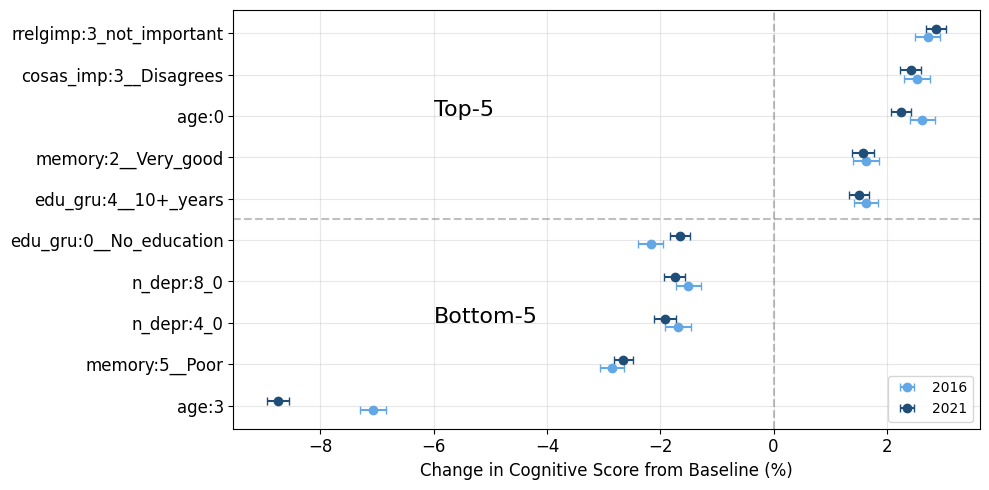

In [134]:
plot_confact_score(plot_data)

### 5.2 Activities

In [135]:
activity_features = ['care_adult', 'care_child', 'volunteer', 'attends_class', 'attends_club',
                     'reads', 'games', 'table_games', 'comms_tel_comp', 'act_mant', 'tv', 'sewing']
results_confact_activities = {k: v for k, v in results_confact.items() if any([feature in k for feature in activity_features])}

In [136]:
list_dfs = []
for key in results_confact_activities:
    df_ = results_confact_activities[key]['test']
    df_ = df_[df_['model'] == 'final']
    df_['feature_category'] = key
    list_dfs.append(df_)

results_confact_activities = pd.concat(list_dfs)


In [137]:
results_confact_activities['feature'] = results_confact_activities['feature_category'].str.split('@').str[0]
results_confact_activities['category'] = results_confact_activities['feature_category'].str.split('@').str[1]
results_confact_activities['feature'] = results_confact_activities['feature'].str.replace('use_confact_test_features_confact_', '')

In [138]:
results_confact_activities_2016 = results_confact_activities[results_confact_activities['year'] == 2016]
results_confact_activities_2021 = results_confact_activities[results_confact_activities['year'] == 2021]

results_confact_activities_2016['predicted_score'] = results_confact_activities_2016['predicted_score'].apply(lambda x: normalize_score(x, score_2016))
results_confact_activities_2021['predicted_score'] = results_confact_activities_2021['predicted_score'].apply(lambda x: normalize_score(x, score_2021))

results_confact_activities = pd.concat([results_confact_activities_2016, results_confact_activities_2021])


In [139]:
# ----- SE -----

def bootstrap_confidence_intervals_activities(data, n_bootstraps=1000):
    """
    Calculate bootstrap means for the 'predicted_score' column.

    Args:
        data (pd.DataFrame): Input data.
        n_bootstraps (int): Number of bootstrap iterations.

    Returns:
        list: Bootstrapped means.
    """
    
    bootstrap_means = []
    for i in range(n_bootstraps):
        bootstrap_sample = data.sample(frac=1, replace=True)
        bootstrap_mean = bootstrap_sample['predicted_score'].mean()
        bootstrap_means.append(bootstrap_mean)

    return bootstrap_means


confact_score_activities = {}

for feature in tqdm(results_confact_activities['feature'].unique()):

    results_test = results_confact_activities[results_confact_activities['feature'] == feature]

    for year in [2016, 2021]:
        results_test_year = results_test[results_test['year'] == year]
        results_test_year_1 = results_test_year[results_test_year['category'] == '1_0']
        results_test_year_0 = results_test_year[results_test_year['category'] == '0_0']

        # Bootstrap means for each category
        bootstrap_means_year_1 = bootstrap_confidence_intervals_activities(results_test_year_1)
        bootstrap_means_year_0 = bootstrap_confidence_intervals_activities(results_test_year_0)

        # Compute bootstrap differences
        bootstrap_diff = np.array(bootstrap_means_year_1) - np.array(bootstrap_means_year_0)

        # Compute the mean difference
        mean_diff = results_test_year_1['predicted_score'].mean() - results_test_year_0['predicted_score'].mean()

        # Compute the standard error (SE) of the differences
        se_diff = np.std(bootstrap_diff, ddof=1)
        se_diff = scale_se(se_diff, len(results_test_year_1), (len(results_test_year_1) + len(results_test_year_0)))

        # Confidence intervals based on SE
        lower_bound_diff = mean_diff - se_diff
        upper_bound_diff = mean_diff + se_diff

        # Optionally scale confidence intervals
        lower_bound_diff, upper_bound_diff = scale_confidence_interval(
            lower_bound_diff, upper_bound_diff, len(results_test_year_1), (len(results_test_year_1) + len(results_test_year_0))
        )

        # Store results
        results_dict = {
            'mean_diff': mean_diff,
            'lower_bound_diff': lower_bound_diff,
            'upper_bound_diff': upper_bound_diff,
        }

        confact_score_activities[f'{feature}_{year}'] = results_dict

100%|██████████| 12/12 [00:03<00:00,  3.05it/s]


In [140]:
df_diff_activities = pd.DataFrame(confact_score_activities)
df_diff_activities = df_diff_activities.T
df_diff_activities = df_diff_activities.reset_index()
df_diff_activities['year'] = df_diff_activities['index'].str[-4:]
df_diff_activities['feature'] = df_diff_activities['index'].str[:-5]
df_diff_activities = df_diff_activities.drop(columns=['index'])

# To wide format
df_diff_activities = df_diff_activities.pivot(index='feature', columns='year', values=['mean_diff', 'lower_bound_diff', 'upper_bound_diff'])

# Concat column names into one
df_diff_activities.columns = df_diff_activities.columns.map(lambda x: f"{x[0]}_{x[1]}")

df_diff_activities = df_diff_activities.reset_index()
df_diff_activities = df_diff_activities.sort_values('mean_diff_2021', ascending=True)

In [141]:
full_variable_names = {
    "attends_club": "Attend sports or social club",
    "comms_tel_comp": "Talk on the phone or send messages/use the web on a computer",
    "table_games": "Play tabletop games (e.g., cards, dominoes, chess)",
    "care_adult": "Look after a sick or disabled adult",
    "care_child": "Look after children under 12",
    "attends_class": "Attend training course, lecture, or class",
    "act_mant": "Maintain a house, do repairs, or garden",
    "tv": "Watch television",
    "sewing": "Sew, embroider, knit, or make crafts",
    "volunteer": "Volunteer for a non-profit",
    "reads": "Read books, magazines, or newspapers",
    "games": "Do crosswords, jigsaw puzzles, or number games",
}
df_diff_activities['feature'] = df_diff_activities['feature'].map(full_variable_names)

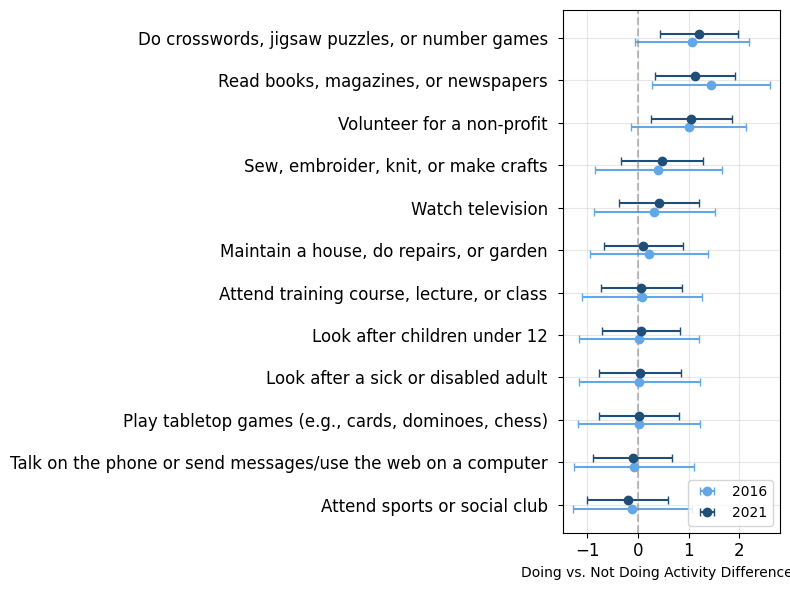

In [142]:
import matplotlib.pyplot as plt

# Create figure with larger size
plt.figure(figsize=(8, 6))

# Offset for separating 2016 and 2021 points
offset = 0.1

# Define y-axis positions
y_positions = range(len(df_diff_activities))

# Plot 2016 data (shifted slightly downward)
plt.errorbar(df_diff_activities['mean_diff_2016'], 
             [y - offset for y in y_positions],  # Shift downward
             xerr=[
                 df_diff_activities['mean_diff_2016'] - df_diff_activities['lower_bound_diff_2016'], 
                 df_diff_activities['upper_bound_diff_2016'] - df_diff_activities['mean_diff_2016']
             ],
             fmt='o', color='#63a7e6', label='2016', capsize=3, alpha=1)

# Plot 2021 data (shifted slightly upward)
plt.errorbar(df_diff_activities['mean_diff_2021'], 
             [y + offset for y in y_positions],  # Shift upward
             xerr=[
                 df_diff_activities['mean_diff_2021'] - df_diff_activities['lower_bound_diff_2021'],
                 df_diff_activities['upper_bound_diff_2021'] - df_diff_activities['mean_diff_2021']
             ],
             fmt='o', color='#1f4e79', label='2021', capsize=3, alpha=1)

# Customize the plot
plt.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
# plt.xlim(-3, 3)  # Set x-axis limits from -3 to 3

plt.grid(True, alpha=0.3)
plt.xlabel('Doing vs. Not Doing Activity Difference (%)', fontsize=10)
# plt.title('Effect of Activity Participation on Cognitive Score', fontsize=14, pad=20)

# Create combined feature and category labels
labels = [f"{row['feature']} " for _, row in df_diff_activities.iterrows()]
plt.yticks(y_positions, labels)

plt.yticks(fontsize=12)
plt.xticks(fontsize=12) 

# Add legend
plt.legend(loc='lower right')

# Adjust layout
plt.tight_layout()
plt.show()